# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

### About COVID-19 Dataset
A database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19 dataset contains 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

In [19]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tqdm import tqdm

torch.manual_seed(0)

In [20]:
print('cuda available' if torch.cuda.is_available() else 'cuda not available')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

cuda available
device: cuda:0


# Data Preparation

In [21]:
class_names = ['normal', 'viral', 'covid', 'lung']
class_fullnames = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung Opacity']

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
root_dir = 'COVID-19_Radiography_Dataset'

test_cases = 100
valid_cases = 100
num_classes = len(class_names)

def create_split(split):
    if not os.path.isdir(os.path.join(root_dir, split)):
        os.mkdir(os.path.join(root_dir, split))

        if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
            for i, d in enumerate(source_dirs):
                os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

        for c in class_names:
            os.mkdir(os.path.join(root_dir, split, c))

        for c in class_names:
            images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
            selected_images = random.sample(images, test_cases)

            for image in selected_images:
                source_path = os.path.join(root_dir, c, image)
                target_path = os.path.join(root_dir, split, c, image)
                shutil.move(source_path, target_path)
            
create_split('valid')
create_split('test')

In [22]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform=None):
        def get_images(class_name):
            images = []
            for x in os.listdir(image_dirs[class_name]):
                if x.lower().endswith('png'):
                    images.append(os.path.join(image_dirs[class_name], x))
            return images
        
        self.images = []
        self.labels = []
        for i, class_name in enumerate(image_dirs):
            class_images = get_images(class_name)
            self.images += class_images
            self.labels += [i] * len(class_images)        
        self.labels = np.array(self.labels)

        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        class_id = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, class_id

In [23]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [24]:
test_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [25]:
train_dirs = {p : os.path.join(root_dir, p) for p in class_names}
test_dirs = {p : os.path.join(root_dir, 'test', p) for p in class_names}
valid_dirs = {p : os.path.join(root_dir, 'valid', p) for p in class_names}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
test_dataset = ChestXRayDataset(test_dirs, test_transform)
valid_dataset = ChestXRayDataset(valid_dirs, test_transform)

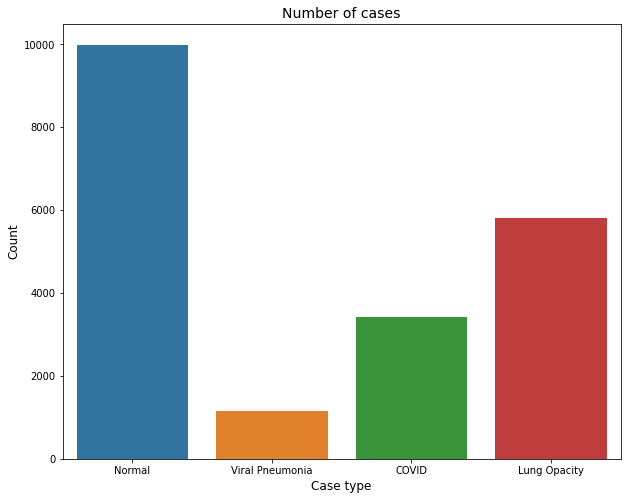

In [26]:
cases_count = []
for idx in range(num_classes):
    cases_count.append(np.sum(train_dataset.labels == idx))
    
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=class_fullnames, y=cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [27]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [28]:
def show_images(images, labels, preds):
    plt.figure(figsize=(14,4))
    for i, image in enumerate(images):
        if i > 5:
            break
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.cpu().detach().numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_fullnames[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_fullnames[int(preds[i].numpy())]}', color=col)

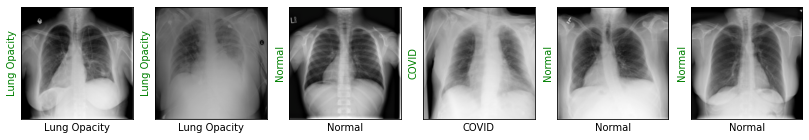

In [29]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

# Modeling

In [30]:
resnet18 = models.resnet18(pretrained=True)

In [31]:
summary(resnet18.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [33]:
resnet18 = resnet18.to(device)

In [34]:
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [35]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = resnet18(images)
    outputs = outputs.cpu().detach()
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

torch.Size([16, 4])


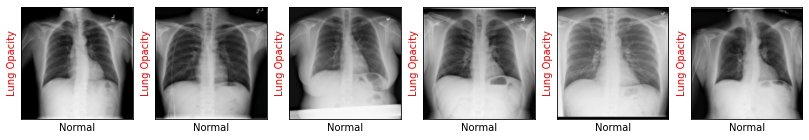

In [36]:
show_preds()

In [41]:
train_losses = []
train_accuracies = []

def train(epoch):
    
    print('\nEpoch : %d' % epoch)

    resnet18.train()
    running_loss = 0
    correct = 0
    total = 0      
    
    for data in tqdm(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
      
    train_loss = running_loss / len(train_loader)
    acc = 100. * correct / total
  
    train_accuracies.append(acc)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f' % (train_loss, acc))          

In [42]:
eval_losses = []
eval_accuracies = []

def test(epoch):
    resnet18.eval()

    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(valid_dataset):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    test_loss = running_loss / len(valid_dataset)
    acc = 100. * correct / total

    eval_losses.append(test_loss)
    eval_accuracies.append(acc)

    print('Test Loss: %.3f | Accuracy: %.3f' % (test_loss, acc)) 

In [43]:
epochs = 10
for epoch in range(1, epochs + 1): 
    train(epoch)
    test(epoch)


Epoch : 1


100%|███████████████████████████████████████| 1273/1273 [01:41<00:00, 12.54it/s]


Train Loss: 0.163 | Accuracy: 94.319


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 16.89it/s]


Test Loss: 0.130 | Accuracy: 94.750

Epoch : 2


100%|███████████████████████████████████████| 1273/1273 [01:41<00:00, 12.49it/s]


Train Loss: 0.123 | Accuracy: 95.674


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 18.16it/s]


Test Loss: 0.159 | Accuracy: 94.750

Epoch : 3


100%|███████████████████████████████████████| 1273/1273 [01:42<00:00, 12.45it/s]


Train Loss: 0.094 | Accuracy: 96.833


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 18.07it/s]


Test Loss: 0.119 | Accuracy: 95.750

Epoch : 4


100%|███████████████████████████████████████| 1273/1273 [01:39<00:00, 12.74it/s]


Train Loss: 0.073 | Accuracy: 97.614


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 17.74it/s]


Test Loss: 0.119 | Accuracy: 95.250

Epoch : 5


100%|███████████████████████████████████████| 1273/1273 [01:41<00:00, 12.60it/s]


Train Loss: 0.053 | Accuracy: 98.281


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 18.84it/s]


Test Loss: 0.134 | Accuracy: 96.250

Epoch : 6


100%|███████████████████████████████████████| 1273/1273 [01:40<00:00, 12.63it/s]


Train Loss: 0.052 | Accuracy: 98.276


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 19.06it/s]


Test Loss: 0.145 | Accuracy: 95.750

Epoch : 7


100%|███████████████████████████████████████| 1273/1273 [01:38<00:00, 12.95it/s]


Train Loss: 0.037 | Accuracy: 98.856


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 18.88it/s]


Test Loss: 0.134 | Accuracy: 96.000

Epoch : 8


100%|███████████████████████████████████████| 1273/1273 [01:39<00:00, 12.76it/s]


Train Loss: 0.027 | Accuracy: 99.175


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 18.13it/s]


Test Loss: 0.138 | Accuracy: 96.000

Epoch : 9


100%|███████████████████████████████████████| 1273/1273 [01:41<00:00, 12.52it/s]


Train Loss: 0.030 | Accuracy: 99.028


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 17.03it/s]


Test Loss: 0.142 | Accuracy: 95.750

Epoch : 10


100%|███████████████████████████████████████| 1273/1273 [01:39<00:00, 12.85it/s]


Train Loss: 0.023 | Accuracy: 99.263


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 19.10it/s]

Test Loss: 0.167 | Accuracy: 95.500


torch.Size([16, 4])


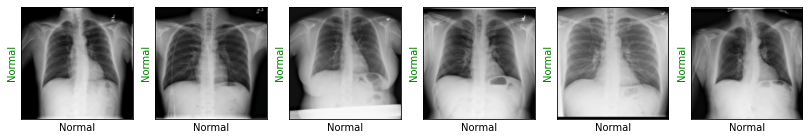

In [50]:
show_preds()

In [57]:
def eval_classifier(model, test_loader, plot_roc_curve = False):
    
    def indices_to_one_hot(data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)
        return np.eye(nb_classes)[targets]
    
    model.eval()
           
    score_list   = torch.Tensor([])
    pred_list    = torch.Tensor([]).long()
    target_list  = torch.Tensor([]).long()
    
    for iter_num, (images, labels) in enumerate(test_loader):        
        images, labels = images.to(device), labels.to(device)        
        outputs = model(images)                
        labels = labels.cpu().detach()    
        outputs = outputs.cpu().detach()        
        score_list   = torch.cat([score_list, torch.nn.Softmax(dim = 1)(outputs).squeeze()])
        target_list  = torch.cat([target_list, labels.squeeze()])
        _, preds = torch.max(outputs, 1)
        pred_list = torch.cat([pred_list, preds.squeeze()])
    
    pred_list   = pred_list.numpy()
    target_list = target_list.numpy()
    score_list  = score_list.numpy()

    print(f'Total accuracy: {np.sum(target_list == pred_list) / len(pred_list) * 100.}%')
    
    cm  = confusion_matrix(target_list, pred_list) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    
    plot_confusion_matrix(cm, hide_ticks=True, cmap=plt.cm.Blues, axis=axes[0])
    
    axes[0].set_xlabel('Predicted labels', fontsize=12)
    axes[0].set_ylabel('True labels', fontsize=12)
    
    axes[0].set_xticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_yticks(range(4), class_fullnames, fontsize=11)
    axes[0].set_title('Confusion Matrix', fontsize=16)
    
    target_list = indices_to_one_hot(target_list, num_classes)
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(target_list[:, i], score_list[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(num_classes):
        
        axes[1].plot(fpr[i], tpr[i], label=f'{class_fullnames[i]} (area = %0.2f)' % roc_auc[i])
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])

        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curve', fontsize=16)
        axes[1].legend(loc="lower right")
        
    plt.tight_layout()  
    plt.show()

Total accuracy: 95.5%


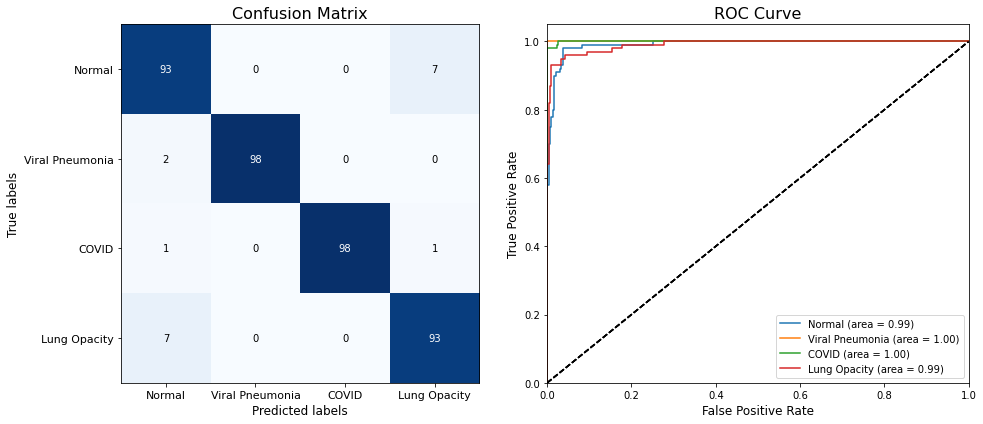

In [58]:
eval_classifier(resnet18, test_loader)